In [129]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.pyplot as plt

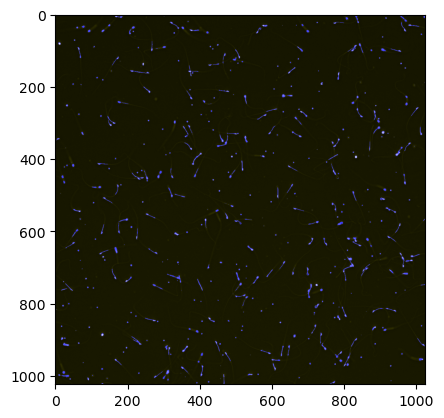

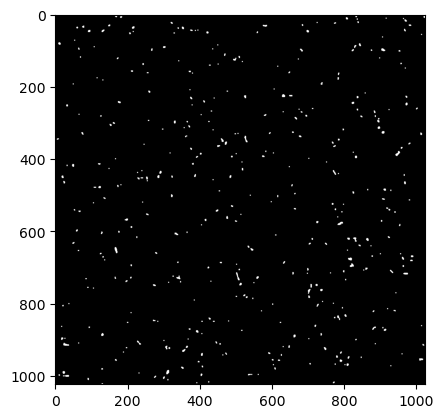

(415, 1, 2)
(381, 5)


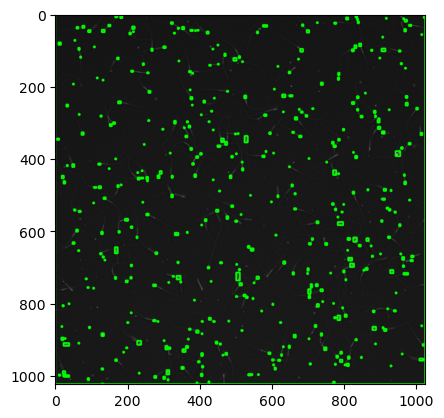

In [139]:
videofile = "29Sep23Data/10X_LD_1024_R1.avi"

cap = cv.VideoCapture(videofile)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)


_, old_bw = cv.threshold(old_gray,50,255,cv.THRESH_BINARY)

vis = np.copy(old_frame)
vis[:,:,2] = old_bw
plt.imshow(vis);plt.show()

#plt.imshow(old_gray,cmap="gray");plt.show()
kernel = np.ones((3,3),np.uint8)
old_bw = cv.morphologyEx(old_bw, cv.MORPH_OPEN, kernel)
plt.imshow(old_bw,cmap="gray");plt.show()


num_labels, label_im, bboxs, centroid = cv.connectedComponentsWithStats(old_bw, 4, cv.CV_32S) 

#print(centroid.shape)
p0 = np.expand_dims(centroid,axis=1).astype(np.float32)
print(p0.shape)

print(values.shape)


vis = np.copy(old_frame)
for i in range(num_labels):
    x = bboxs[i,0]
    y = bboxs[i,1]
    w = bboxs[i,2]
    h = bboxs[i,3]
    cv.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.imshow(vis);plt.show()





## Naive Bounding Box Approach

In [111]:
result_vid = cv.VideoWriter("output.mp4",cv.VideoWriter_fourcc(*'MJPG'),10,(old_bw.shape[1],old_bw.shape[0]))

# Create some random colors
color = np.random.randint(0, 255, (p0.shape[0], 3))


# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]


    # Draw the bounding boxes
    _, frame_bw = cv.threshold(frame_gray,30,255,cv.THRESH_BINARY)
    num_labels, label_im, bboxs, centroid = cv.connectedComponentsWithStats(frame_bw, 4, cv.CV_32S) 
    
    mask_bboxs = np.zeros_like(frame)

    for i in range(num_labels):
        x = bboxs[i,0]
        y = bboxs[i,1]
        w = bboxs[i,2]
        h = bboxs[i,3]
        mask_bboxes = cv.rectangle(mask_bboxs, (x, y), (x + w, y + h), (0, 128, 0), 3)
    img = cv.add(frame, mask_bboxs)
    
    
    # draw the tracks
    #for i, (new, old) in enumerate(zip(good_new, good_old)):
    #    a, b = new.ravel()
    #    c, d = old.ravel()
    #    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
    #    frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    #img = cv.add(frame, mask)

    result_vid.write(img)

    cv.imshow('frame', img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

result_vid.release()

cv.destroyAllWindows()

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


KeyboardInterrupt: 

## Intelligent Bounding Box Approach

In [140]:
def seeded_connected_components(thresh_im,centroids):
    """
    This function takes a thresholded image and a set of centroids and returns the connected components relative to those centroids
    """

    # Get Naive Connected Components
    _, label_im, bboxs, _ = cv.connectedComponentsWithStats(thresh_im, 4, cv.CV_32S)

    #print(centroids.shape)

    # Start with an empty image and bboxs list and add to them based on the centroids
    new_label_im = np.zeros_like(label_im) - 1
    new_bboxs = []
    for i, centroid in enumerate(centroids):
        # Get the label of the centroid

        r,c = int(centroid[1]),int(centroid[0])

        if r < 0 or c < 0 or r >= label_im.shape[0] or c >= label_im.shape[1]:
            continue

        label = label_im[r,c]

        # Check that it did not hit the background
        if bboxs[label,2] > label_im.shape[0]/2:
            continue

        # Add the label to the new label image
        new_label_im[label_im==label] = i #len(new_bboxs)
        # Add the bbox to the new bboxs
        new_bboxs.append(bboxs[label])

    # Convert the bboxs to a numpy array
    new_bboxs = np.array(new_bboxs)

    # Get the number of labels
    num_labels = len(new_bboxs)

    # Return the new label image and bboxs
    return num_labels, new_label_im, new_bboxs

In [141]:
result_vid = cv.VideoWriter("output.mp4",cv.VideoWriter_fourcc(*'MJPG'),10,(old_bw.shape[1],old_bw.shape[0]))

# Create some random colors
color = np.random.randint(0, 255, (p0.shape[0], 3))


# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]


    # Find Seeded Connected Components
    _, frame_bw = cv.threshold(frame_gray,30,255,cv.THRESH_BINARY)
    num_labels, label_im, bboxs = seeded_connected_components(frame_bw,good_new)
    
    # Draw the bounding boxes
    #mask_bboxs = np.zeros_like(frame)

    #for i in range(num_labels):
    #    x = bboxs[i,0]
    #    y = bboxs[i,1]
    #    w = bboxs[i,2]
    #    h = bboxs[i,3]
    #    mask_bboxes = cv.rectangle(mask_bboxs, (x, y), (x + w, y + h), (0, 128, 0), 3)
    #img = cv.add(frame, mask_bboxs)
    
    # Draw the image label as random colors
    mask = color[label_im]
    mask = mask.astype(np.uint8)
    #plt.imshow(mask);plt.show()
    black_mask = label_im!=-1
    #plt.imshow(black_mask,cmap="gray");plt.show()
    mask *= black_mask[:,:,None]
    #plt.imshow(mask);plt.show()
    img = cv.add(frame, mask)


    # draw the tracks
    #for i, (new, old) in enumerate(zip(good_new, good_old)):
    #    a, b = new.ravel()
    #    c, d = old.ravel()
    #    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
    #    frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    #img = cv.add(frame, mask)

    result_vid.write(img)

    cv.imshow('frame', img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

result_vid.release()

cv.destroyAllWindows()

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


No frames grabbed!


: 